# Umap acceleration using Rapids

UMAP is a powerful dimensionality reduction tool that can benefit from GPU acceleration. 

In [6]:
import os
import cudf
import umap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.manifold.t_sne import trustworthiness
from cuml.manifold.umap import UMAP as cumlUMAP

%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

print('cuDF:', cudf.__version__)
print('pandas:', pd.__version__)
print('umap:', umap.__version__)

cuDF: 0.9.0
pandas: 0.24.2
umap: 0.3.10


In [13]:
dataset_folder = 'fashion_mnist'
if not os.path.exists(dataset_folder):
    !git clone https://github.com/zalandoresearch/fashion-mnist.git fashion_mnist

In [14]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [17]:
dataset = os.path.join(dataset_folder, 'data/fashion')
print('Loading dataset:', dataset)

Loading dataset: fashion_mnist/data/fashion


In [20]:
train, train_labels = load_mnist(dataset, kind='train')
test, test_labels = load_mnist(dataset, kind='t10k')
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.array(np.hstack([train_labels, test_labels]))

In [21]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"

'Train shape: (60000, 784) and Test Shape: (10000, 784)'

### Render sample image

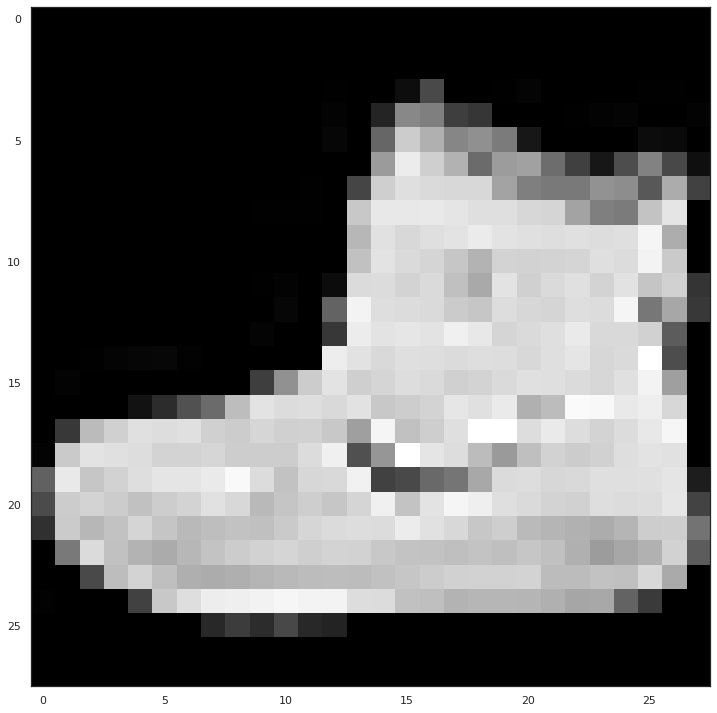

In [23]:
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

In [30]:
%%time

record_data = (('fea%d'%i, data[:, i]) for i in range(data.shape[1]))
gdf = cudf.DataFrame(record_data)


CPU times: user 1.09 s, sys: 237 ms, total: 1.33 s
Wall time: 1.33 s


In [31]:
gdf.head(3)

,fea0,fea1,fea2,fea3,fea4,fea5,fea6,fea7,fea8,fea9,...,fea774,fea775,fea776,fea777,fea778,fea779,fea780,fea781,fea782,fea783
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.0,0.000000,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.086275,...,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# hide warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [34]:
%%timeit
g_embedding = cumlUMAP(n_neighbors=5, init='spectral').fit_transform(gdf)

/home/martin/anaconda3/envs/rapidsai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/home/martin/anaconda3/envs/rapidsai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/home/martin/anaconda3/envs/rapidsai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/home/martin/anaconda3/envs/rapidsai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  

4.15 s ± 96.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
embedding = umap.UMAP(n_neighbors=5, init="spectral").fit_transform(data)

/home/martin/anaconda3/envs/rapidsai/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/rapidsai/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/martin/anaconda3/envs/rapidsai/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/r

1min 3s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

In [37]:
embedding = umap.UMAP(n_neighbors=5, init="spectral").fit_transform(data)
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)

/home/martin/anaconda3/envs/rapidsai/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/rapidsai/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/martin/anaconda3/envs/rapidsai/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


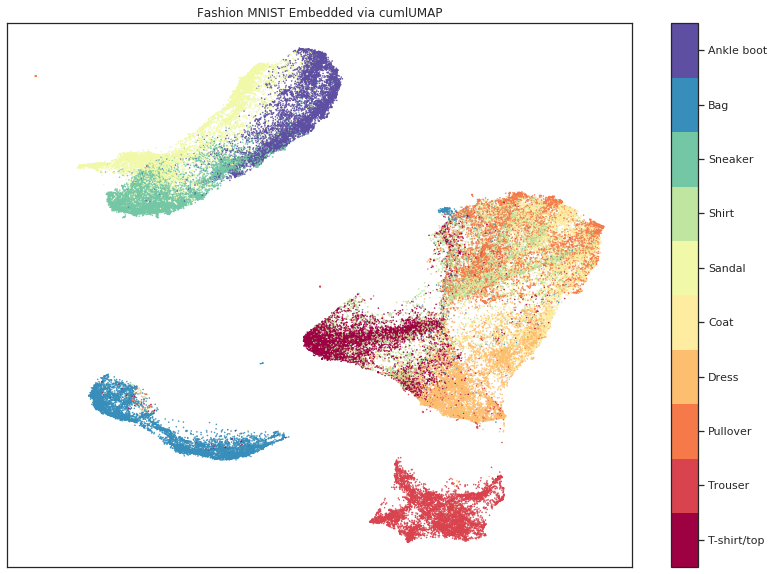

In [38]:

g_embedding_numpy = g_embedding.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via cumlUMAP');

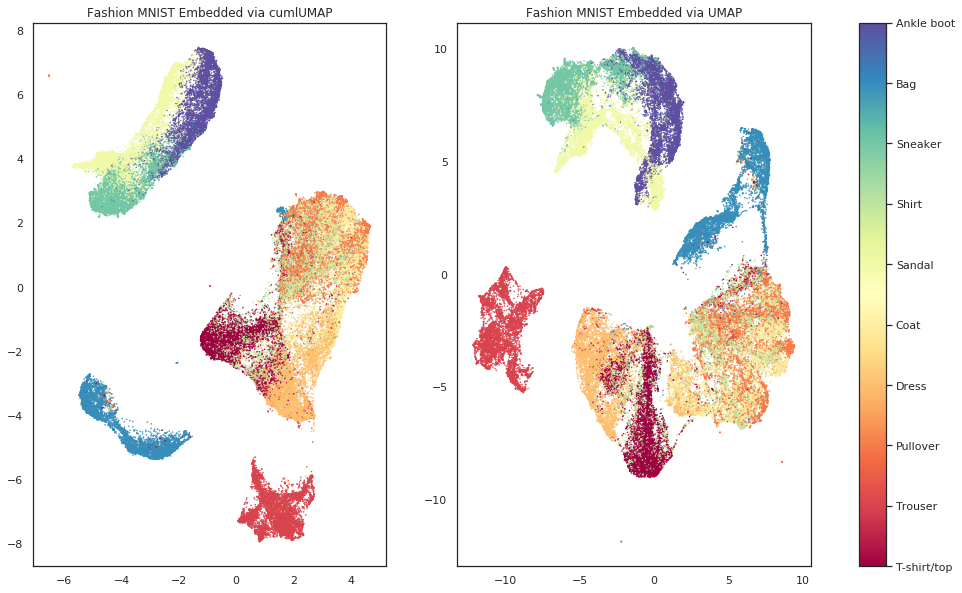

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
im = ax[1].scatter(embedding[:,1], embedding[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
ax[0].set_title('Fashion MNIST Embedded via cumlUMAP');
ax[1].set_title('Fashion MNIST Embedded via UMAP');

fig.subplots_adjust(right=0.8)
cax,kw = mpl.colorbar.make_axes([a for a in ax.flat])
cbar = plt.colorbar(im, cax=cax, **kw)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)